In [2]:
from matplotlib import pyplot as plt
import mne
import numpy as np
import os 

# Install mne  
https://mne.tools/stable/install/manual_install.html#manual-install 

Reading /Users/marierose/Desktop/Bioinformatics/advanced python/EEG_Project/group_3_eeg/data/PHY_ID0000-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =       0.00 ...   29990.00 ms
        0 CTF compensation matrices available
Not setting metadata
841 matching events found
No baseline correction applied
0 projection items activated
(841, 7, 3000)
(7, 3000)
(3000,)
[0 0 0 0 0 0 0 0 0 0]
841
Stage for epoch 25: 0


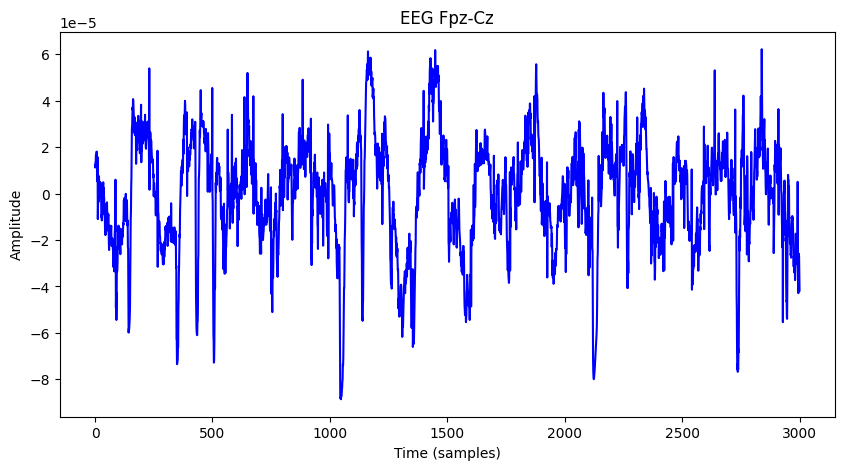

In [3]:
# PSG
epo = mne.read_epochs('data/PHY_ID0000-epo.fif', preload=True)
data = epo.get_data(copy=True)


print(data.shape) # (n_epochs, n_channels, n_times)
print(data[0].shape) # (n_channels, n_times)
print(data[0][0].shape) # (n_times,)

print(epo.events[:10, 2]) # first 10 sleep stage labels
print(len(epo.events[:, 2])) # number of events
# Plotting
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(data[25][0], label='EEG Fpz-Cz', color='blue')
ax.set_title('EEG Fpz-Cz')
ax.set_xlabel('Time (samples)')
ax.set_ylabel('Amplitude')

# get the sleep stage 
labels = epo.events[:, 2]
print(f'Stage for epoch 25: {labels[25]}')


In [4]:
# get the channel names 
epo.ch_names
epo.events

array([[2883000,       0,       0],
       [2886000,       0,       0],
       [2889000,       0,       0],
       ...,
       [5397000,       0,       0],
       [5400000,       0,       0],
       [5403000,       0,       0]], shape=(841, 3), dtype=int32)

In [5]:

epo.ch_names


['EEG Fpz-Cz',
 'EEG Pz-Oz',
 'EOG horizontal',
 'Resp oro-nasal',
 'EMG submental',
 'Temp rectal',
 'Event marker']

dict_items([('Sleep stage W', 0), ('Sleep stage 1', 1), ('Sleep stage 2', 2), ('Sleep stage 3/4', 3), ('Sleep stage R', 4)])


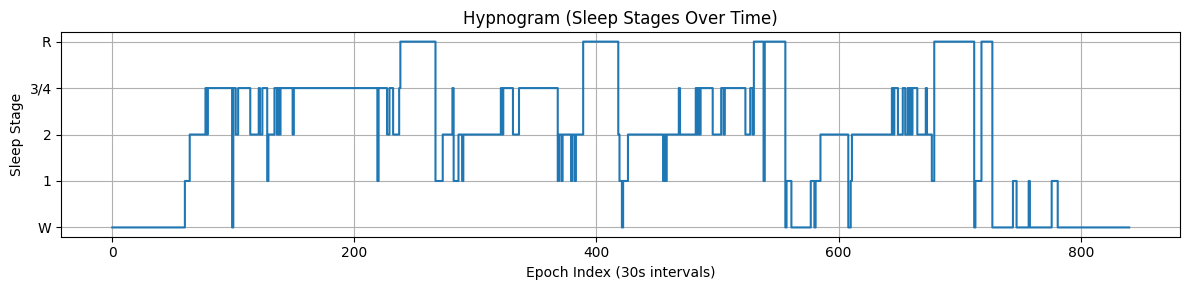

In [4]:
#There are 4 sleep stages in oiur data: W,1,2,3/4, R. I assume, W means awake and R means REM. For each epoch, there is 1 sleep stage value.
# An epoch is 30s long according to google (I think thats standard for eegs)
#

# get the sleep stage 
stage = epo.events[:, 2]
#Un comment the following line to see relationship between integer and sleep stage
print(epo.event_id.items())

#These lines just swap the integer with the string of the sleep stage, 



stage_labels = ['W', '1', '2', '3/4', 'R']
labels_named = [stage_labels[int(l)] if l >= 0 else 'Unknown' for l in stage]


#This plots the sleep stage for each epoch(30s)
plt.figure(figsize=(12, 3))
plt.plot( labels, drawstyle='steps-post')
plt.yticks(ticks=[0, 1, 2, 3, 4], labels=stage_labels)
plt.xlabel('Epoch Index (30s intervals)')
plt.ylabel('Sleep Stage')
plt.title('Hypnogram (Sleep Stages Over Time)')
plt.grid(True)
plt.tight_layout()
plt.show()

#I guess the next step would be to run a for loop and do this for every file? Im confused because the github says we have data from 25 patients,
#  but we have 75 fif files



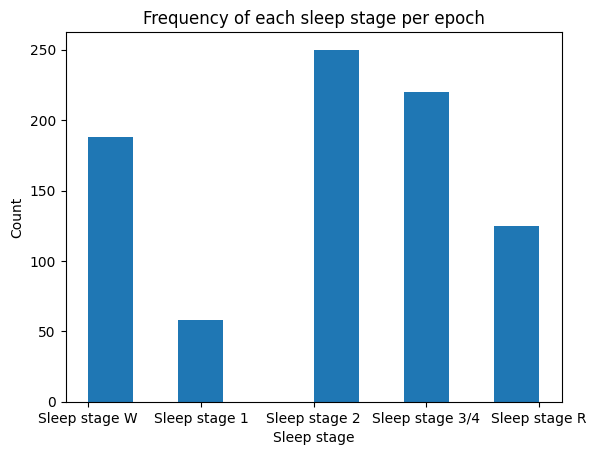

In [12]:
#Plot a histogram of each sleep stage, using the first patient and epoch

from collections import Counter

reverse_labels = {v: k for k,v in epo.event_id.items()}
label_names = [reverse_labels[l] for l in stage]
#print(reverse_labels)

label_counts = Counter(label_names)
#print(label_counts)
stages = list(label_counts.keys())
counts = list(label_counts.values())

#Can loop this for every epoch if needed

plt.hist(label_names)
plt.xlabel("Sleep stage")
plt.ylabel("Count")
plt.title("Frequency of each sleep stage per epoch")
plt.show()

In [ ]:
#Normalizing the data. Not quite sure why we need to do this yet but. Like i said aove, just need to do a for loop like above and do it for each sample


mean = data.mean(axis=2, keepdims=True)
std =data.std(axis=2, keepdims=True)
normalized = (data - mean) / std
print(normalized.shape)

#For loop will look something like this:

"""
data_dir = 'data'
patient_files = [f for f in os.listdir(data_dir) if f.endswith('-epo.fif')]

all_normalized_data = []

for i, fname in enumerate(sorted(patient_files)):
    path = os.path.join(data_dir, fname)

    epo = mne.read_epochs(path, preload=True)
    data = epo.get_data(copy=True)

    mean = data.mean(axis=2, keepdims=True)
    std =data.std(axis=2, keepdims=True)
    normalized = (data - mean) / std

    all_normalized_data.append(normalized)

"""
    

(841, 7, 3000)
posix.uname_result(sysname='Darwin', nodename='claudias-macbook-pro.home', release='24.3.0', version='Darwin Kernel Version 24.3.0: Thu Jan  2 20:22:00 PST 2025; root:xnu-11215.81.4~3/RELEASE_X86_64', machine='x86_64')


# Looking at all the files we have

Okay, let's look at 
- all the different combinations of age+gender from the `subject_info` property:
- dates of measurement
- the `his_id` property of `subject_info`

In [7]:
import os
from collections import defaultdict
from datetime import datetime
_,_,fileNames = os.walk('./data').__next__()
result = defaultdict(set)
date_taken = defaultdict(set)
id_property = defaultdict(int)
print('old log level:', mne.set_log_level('ERROR', return_old_level=True), 'changing to reduce trash in output')
for fname in fileNames:
  f_data = mne.read_epochs(f'./data/{fname}')
  
  s_inf = f_data.info['subject_info']
  hash = f"{s_inf['first_name']}{s_inf['last_name']}" # our data is terrible, so inside first_name there is gender, and last_name field has age
  result[hash].add(fname)

  date_taken[f_data.info['meas_date'].date()].add(fname)

  id_property[s_inf['his_id']] += 1

assert len(fileNames) == sum([len(v) for v in result.values()])
print('Unique Age+Gender combos:', len(result.keys()))
print('Unique Date combos:', len(date_taken.keys()))
print('IDs found across all the files:', id_property.items())
result


old log level: 20 changing to reduce trash in output
Unique Age+Gender combos: 48
Unique Date combos: 58
IDs found across all the files: dict_items([('X', 76)])


defaultdict(set,
            {'Male60yr': {'PHY_ID00033-epo.fif'},
             'Male49yr': {'PHY_ID00023-epo.fif'},
             'Male73yr': {'PHY_ID00051-epo.fif'},
             'Female73yr': {'PHY_ID00041-epo.fif', 'PHY_ID00045-epo.fif'},
             'Female25yr': {'PHY_ID0008-epo.fif', 'PHY_ID0009-epo.fif'},
             'Male88yr': {'PHY_ID00066-epo.fif', 'PHY_ID00067-epo.fif'},
             'Male31yr': {'PHY_ID00015-epo.fif', 'PHY_ID00017-epo.fif'},
             'Male71yr': {'PHY_ID00048-epo.fif', 'PHY_ID00052-epo.fif'},
             'Female101yr': {'PHY_ID00058-epo.fif'},
             'Female33yr': {'PHY_ID0000-epo.fif', 'PHY_ID0001-epo.fif'},
             'Male27yr': {'PHY_ID00013-epo.fif', 'PHY_ID00014-epo.fif'},
             'Female95yr': {'PHY_ID00059-epo.fif'},
             'Male70yr': {'PHY_ID00049-epo.fif'},
             'Female56yr': {'PHY_ID00022-epo.fif',
              'PHY_ID00025-epo.fif',
              'PHY_ID00028-epo.fif',
              'PHY_ID00075-epo.fif'},
  

That does not tell us much. In an adversarial example, we could check for differences in dates and ages of patients between measurement points, and slightly reduce the count (case that Male57 measured in 1990 will be Male58 in 1991), but not only does the data look like it wouldn't change much, we have no deterministic way of verifying these matches.  

In [81]:
print('unique dates', len(date_taken.keys()))
date_taken

unique dates 58


defaultdict(set,
            {datetime.date(1990, 3, 19): {'PHY_ID00033-epo.fif'},
             datetime.date(1989, 6, 28): {'PHY_ID00023-epo.fif'},
             datetime.date(1990, 3, 12): {'PHY_ID00043-epo.fif',
              'PHY_ID00051-epo.fif'},
             datetime.date(1989, 6, 12): {'PHY_ID00041-epo.fif'},
             datetime.date(1989, 6, 5): {'PHY_ID0009-epo.fif'},
             datetime.date(1989, 10, 5): {'PHY_ID00067-epo.fif'},
             datetime.date(1989, 6, 21): {'PHY_ID00015-epo.fif'},
             datetime.date(1989, 5, 1): {'PHY_ID00011-epo.fif',
              'PHY_ID00048-epo.fif'},
             datetime.date(1989, 9, 6): {'PHY_ID00058-epo.fif'},
             datetime.date(1989, 4, 24): {'PHY_ID0000-epo.fif',
              'PHY_ID0004-epo.fif'},
             datetime.date(1989, 9, 26): {'PHY_ID00066-epo.fif'},
             datetime.date(1989, 6, 19): {'PHY_ID00014-epo.fif',
              'PHY_ID00030-epo.fif'},
             datetime.date(1989, 3, 29): {'PHY_ID

In [ ]:
def channel_plots(epo_file_path, channels, stages):
    epo = mne.read_epochs(epo_file_path, preload=True) # get the patient file
    
    for channel in channels:
        channel_data = epo.pick_channels(channels) # pick the channles we are interested in
        plot_data = [None]*len(stages)
        for i, stage in enumerate(stages):
            stage_data = channel_data[channel_data.events[:,2] == stage].get_data(copy=True) # convert the data from the mne object
            # to a multidimensional array, only take the data of the wanted sleep stage
            unstacked_stage_data = np.unstack(stage_data[:,0,:], axis = 0) # unstack the data
            plot_data[i] = np.hstack(unstacked_stage_data) # make it into a one dimensional array and store it in plot_data list
        plt.boxplot(plot_data, showmeans=True) # plot the different channels as boxplot
        plt.title(channel)
        plt.show()
        # todo: adjust xlab labels, add std, make nice layout with subplots, maybe other stuff too
channel_plots('data/PHY_ID0000-epo.fif', ['EEG Fpz-Cz','EEG Pz-Oz', 'EOG horizontal'], [0,1,2])